# **Sim Output to EcoCyc Data Comparison**

In [1]:
import numpy as np
import pandas as pd
import statistics
import math
import seaborn as sns
import matplotlib.pyplot as plt
import ast

In [2]:
logTransposeConst = 1

def notPresent(key, complexesFunc):
    amounts = complexesFunc[key]
    for num in amounts:
        if not num == 0:
            return False
    return True
    
def zeroFlux(key, dictionary):
    fluxes = dictionary[key]
    for num in fluxes:
        if not num == 0:
            return False
    return True


def createTuples(dictionary):
    result = []
    keys = dictionary.keys()
    for key in keys:
        mean = statistics.mean(dictionary[key])
        result.append(tuple((key, mean)))
    return result


def getZeroFluxReactions(reactionDictionary):
    reactions = reactionDictionary.keys()
    zeroFluxReactions = []

    for key in reactions:
        if zeroFlux(key, reactionDictionary):
            zeroFluxReactions.append(key)
            
    return zeroFluxReactions


def createHeatMapFluxes(reactionDictionary, mapHeight, annot_grid):
    reactions = reactionDictionary.keys()
    zeroFluxReactions = []
    nonZeroFlux = {}

    for key in reactions:
        if zeroFlux(key, reactionDictionary):
            zeroFluxReactions.append(key)
        else:
            res = [abs(ele) for ele in reactionDictionary[key]]
            nonZeroFlux[key] = res

    transformedData = {}
    for key in nonZeroFlux.keys():
        new = []
        old = nonZeroFlux[key]
        for val in old:
            new.append(math.log(val + logTransposeConst))
        transformedData[key] = new

    tuples = createTuples(transformedData)
    tuples.sort(key=lambda x: x[1])

    sortedReactions = {}
    for elem in tuples:
        key = elem[0]
        sortedReactions[key] = transformedData[key]

    df = pd.DataFrame.from_dict(sortedReactions, orient='index')
    df.index.name = 'Reactions'
    df.reset_index(inplace=False)
    
    revertedCounts = {}
    for key in sortedReactions.keys():
        temp = []
        for val in sortedReactions[key]:
            temp.append((math.e ** val) - 1)
        revertedCounts[key] = temp

    df2 = pd.DataFrame.from_dict(revertedCounts, orient='index')
    df2.index.name = 'Reactions'
    df2.reset_index(inplace=False)
    
    fig, ax = plt.subplots(figsize=(50, mapHeight))
    plt.xlabel("Seconds")
    if annot_grid:
        sns.heatmap(df, cmap="rocket_r", linewidths=.5, annot=df2)
    else:
        sns.heatmap(df, cmap="rocket_r")
    return 

def createHeatMapComplexes(complexes, mapHeight, annot_grid):
    complexNames = complexes.keys()
    zeroQuantComplexes = []
    presentComplexes = {}

    for key in complexes:
        if notPresent(key, complexes):
            zeroQuantComplexes.append(key)
        else:
            presentComplexes[key] = complexes[key]

    transformedData = {}
    for key in presentComplexes.keys():
        new = []
        old = presentComplexes[key]
        for val in old:
            new.append(math.log(val + logTransposeConst))
        transformedData[key] = new

    tuples = createTuples(transformedData)
    tuples.sort(key=lambda x: x[1])

    sortedComplexes = {}
    for elem in tuples:
        key = elem[0]
        sortedComplexes[key] = transformedData[key]

    df = pd.DataFrame.from_dict(sortedComplexes, orient='index')
    df.index.name = 'Reactions'
    df.reset_index(inplace=False)

    fig, ax = plt.subplots(figsize=(50, mapHeight))
    plt.xlabel("Seconds")
    if annot_grid:
        sns.heatmap(df, cmap="rocket_r", linewidths=.5, annot=True)
    else:
        sns.heatmap(df, cmap="rocket_r")

    return 

In [3]:
simData = np.load(r"../../out/geneRxnVerifData/output.npy", allow_pickle=True, encoding='ASCII')
fluxesWithCaption = simData.tolist()['agents']['0']['listeners']['fba_results']['estimated_fluxes']
complexes = simData.tolist()['agents']['0']['bulk']

ecData = pd.read_csv(r"../new genes/geneData.txt")
ecReactions = ecData["reactionID"].values.tolist()
temp = []
for word in ecReactions:
    if not word == "No Reaction Found":
        temp.append(word)
ecReactions = temp

metabolData = np.load(r"../../out/geneRxnVerifData/stoichiometry.npy", allow_pickle=True, encoding='ASCII')
rxn_metabolites = metabolData.tolist()

### **Sim Output: Reaction Flux Analysis**

#### *Run Following Block to visualize reactions with Flux throughout time frame*

In [ ]:
createHeatMapFluxes(fluxesWithCaption, 650, True)

#### *Run Following Block to identify reactions with Zero Flux throughout time frame*

In [ ]:
rxns = getZeroFluxReactions(fluxesWithCaption)
print(len(rxns), "zero flux reactions found.")
enter = input("Press 'Enter' to show reaction names. Click any other key to contintue")
if enter == "":
    print(rxns)

### **Sim Output: Complex Analysis**

#### *Run Following Block to visualize complexes present during time frame*

In [ ]:
createHeatMapComplexes(complexes, 650, False)

#### *Run Following Block to identify complexes not present throughout time frame*

In [8]:
zeroQuant = []
for key in complexes.keys():
    if notPresent(key, complexes):
        zeroQuant.append(key)
        
print(len(zeroQuant), "complexes not found.")
enter = input("Press 'Enter' to show reaction names. Click any other key to contintue")
if enter == "":
    print(zeroQuant)     

35804 complexes not found.


Press 'Enter' to show reaction names. Click any other key to contintue wdc


#### *Run Following Block to identify complexes with incorrect compartments*

In [6]:
incorrectCompartments = []
for complex_ in complexes:
    if not (complex_[len(complex_) - 1 - 2] == '[' and complex_[len(complex_) - 1] == ']'):
        incorrectCompartments.append(complex_)

print(len(incorrectCompartments), "incorrect compartments found.")
enter = input("Press 'Enter' to show complex names. Click any other key to contintue")
if enter == "":
    print(incorrectCompartments)

0 incorrect compartments found.


Press 'Enter' to show complex names. Click any other key to contintue sf


### **EcoCyc Comparison: Reaction Flux**

#### *Run following block before any other block in this section* **Block A**

In [11]:
reactionsSim = fluxesWithCaption.keys()

foundReactions = {}
unfoundReactions = []

for reaction in ecReactions:
    x = 0
    for reactionSim in reactionsSim:
        if reaction in reactionSim:
            index = reactionSim.find(reaction)
            indexOfNextChar = index + len(reaction)
            if indexOfNextChar >= len(reactionSim) or not (reactionSim[indexOfNextChar].isdigit() or reactionSim[indexOfNextChar].isalpha()):
                x = 1
                key = "(" + reaction + ")" + reactionSim
                foundReactions[key] = fluxesWithCaption[reactionSim]
    if x == 0:
        unfoundReactions.append(reaction)

#### *Run following block to identify EcoCyc reactions not found in Simulation*

In [12]:
print(len(unfoundReactions), "reactions not present.")
enter = input("Press 'Enter' to show complex names. Click any other key to contintue")
if enter == "":
    print(unfoundReactions)

18 reactions not present.


Press 'Enter' to show complex names. Click any other key to contintue db


#### *Run following block to identify EcoCyc reactions with No Flux in Simulation*

In [13]:
rxns1 = getZeroFluxReactions(foundReactions)
print(len(rxns1), "zero flux reactions found.")
enter = input("Press 'Enter' to show reaction names. Click any other key to contintue")
if enter == "":
    print(rxns1)

512 zero flux reactions found.


Press 'Enter' to show reaction names. Click any other key to contintue 


['(ISOCIT-CLEAV-RXN)ISOCIT-CLEAV-RXN', '(MALSYN-RXN)MALSYN-RXN', '(TRANS-RXN-360)TRANS-RXN-360', '(TRANS-RXN-352)TRANS-RXN-352', '(TRANS-RXN-367)TRANS-RXN-367-CPD-13804/PROTON//CPD-13804/PROTON.35.', '(TRANS-RXN-354)TRANS-RXN-354', '(TRANS-RXN-355)TRANS-RXN-355', '(RXN0-1981)RXN0-1981', '(RXN0-5111)RXN0-5111', '(TRANS-RXN0-576)TRANS-RXN0-576', '(TRANS-RXN0-447)TRANS-RXN0-447', '(RXN0-2162)RXN0-2162', '(ACETYLESTERASE-RXN)ACETYLESTERASE-RXN-ETHYLACETATE/WATER//ETOH/ACET/PROTON.37.', '(RXN-13548)RXN-13548', '(GLUCOSE-1-PHOSPHAT-RXN)GLUCOSE-1-PHOSPHAT-RXN[CCO-CYTOSOL]-GLC-1-P/WATER//ALPHA-GLUCOSE/Pi.45.', '(GLUCOSE-1-PHOSPHAT-RXN)GLUCOSE-1-PHOSPHAT-RXN[CCO-CYTOSOL]-GLC-1-P/WATER//GLC/Pi.35.', '(GLUCOSE-1-PHOSPHAT-RXN)GLUCOSE-1-PHOSPHAT-RXN[CCO-CYTOSOL]-GLC-1-P/WATER//Glucopyranose/Pi.45.', '(GLUCOSE-1-PHOSPHAT-RXN)GLUCOSE-1-PHOSPHAT-RXN[CCO-PERI-BAC]-GLC-1-P/WATER//ALPHA-GLUCOSE/Pi.46.', '(GLUCOSE-1-PHOSPHAT-RXN)GLUCOSE-1-PHOSPHAT-RXN[CCO-PERI-BAC]-GLC-1-P/WATER//ALPHA-GLUCOSE/Pi.46.__GLU

#### *Run following block to visualize non-zero fluxes for EcoCyc reactions found in Simulation*

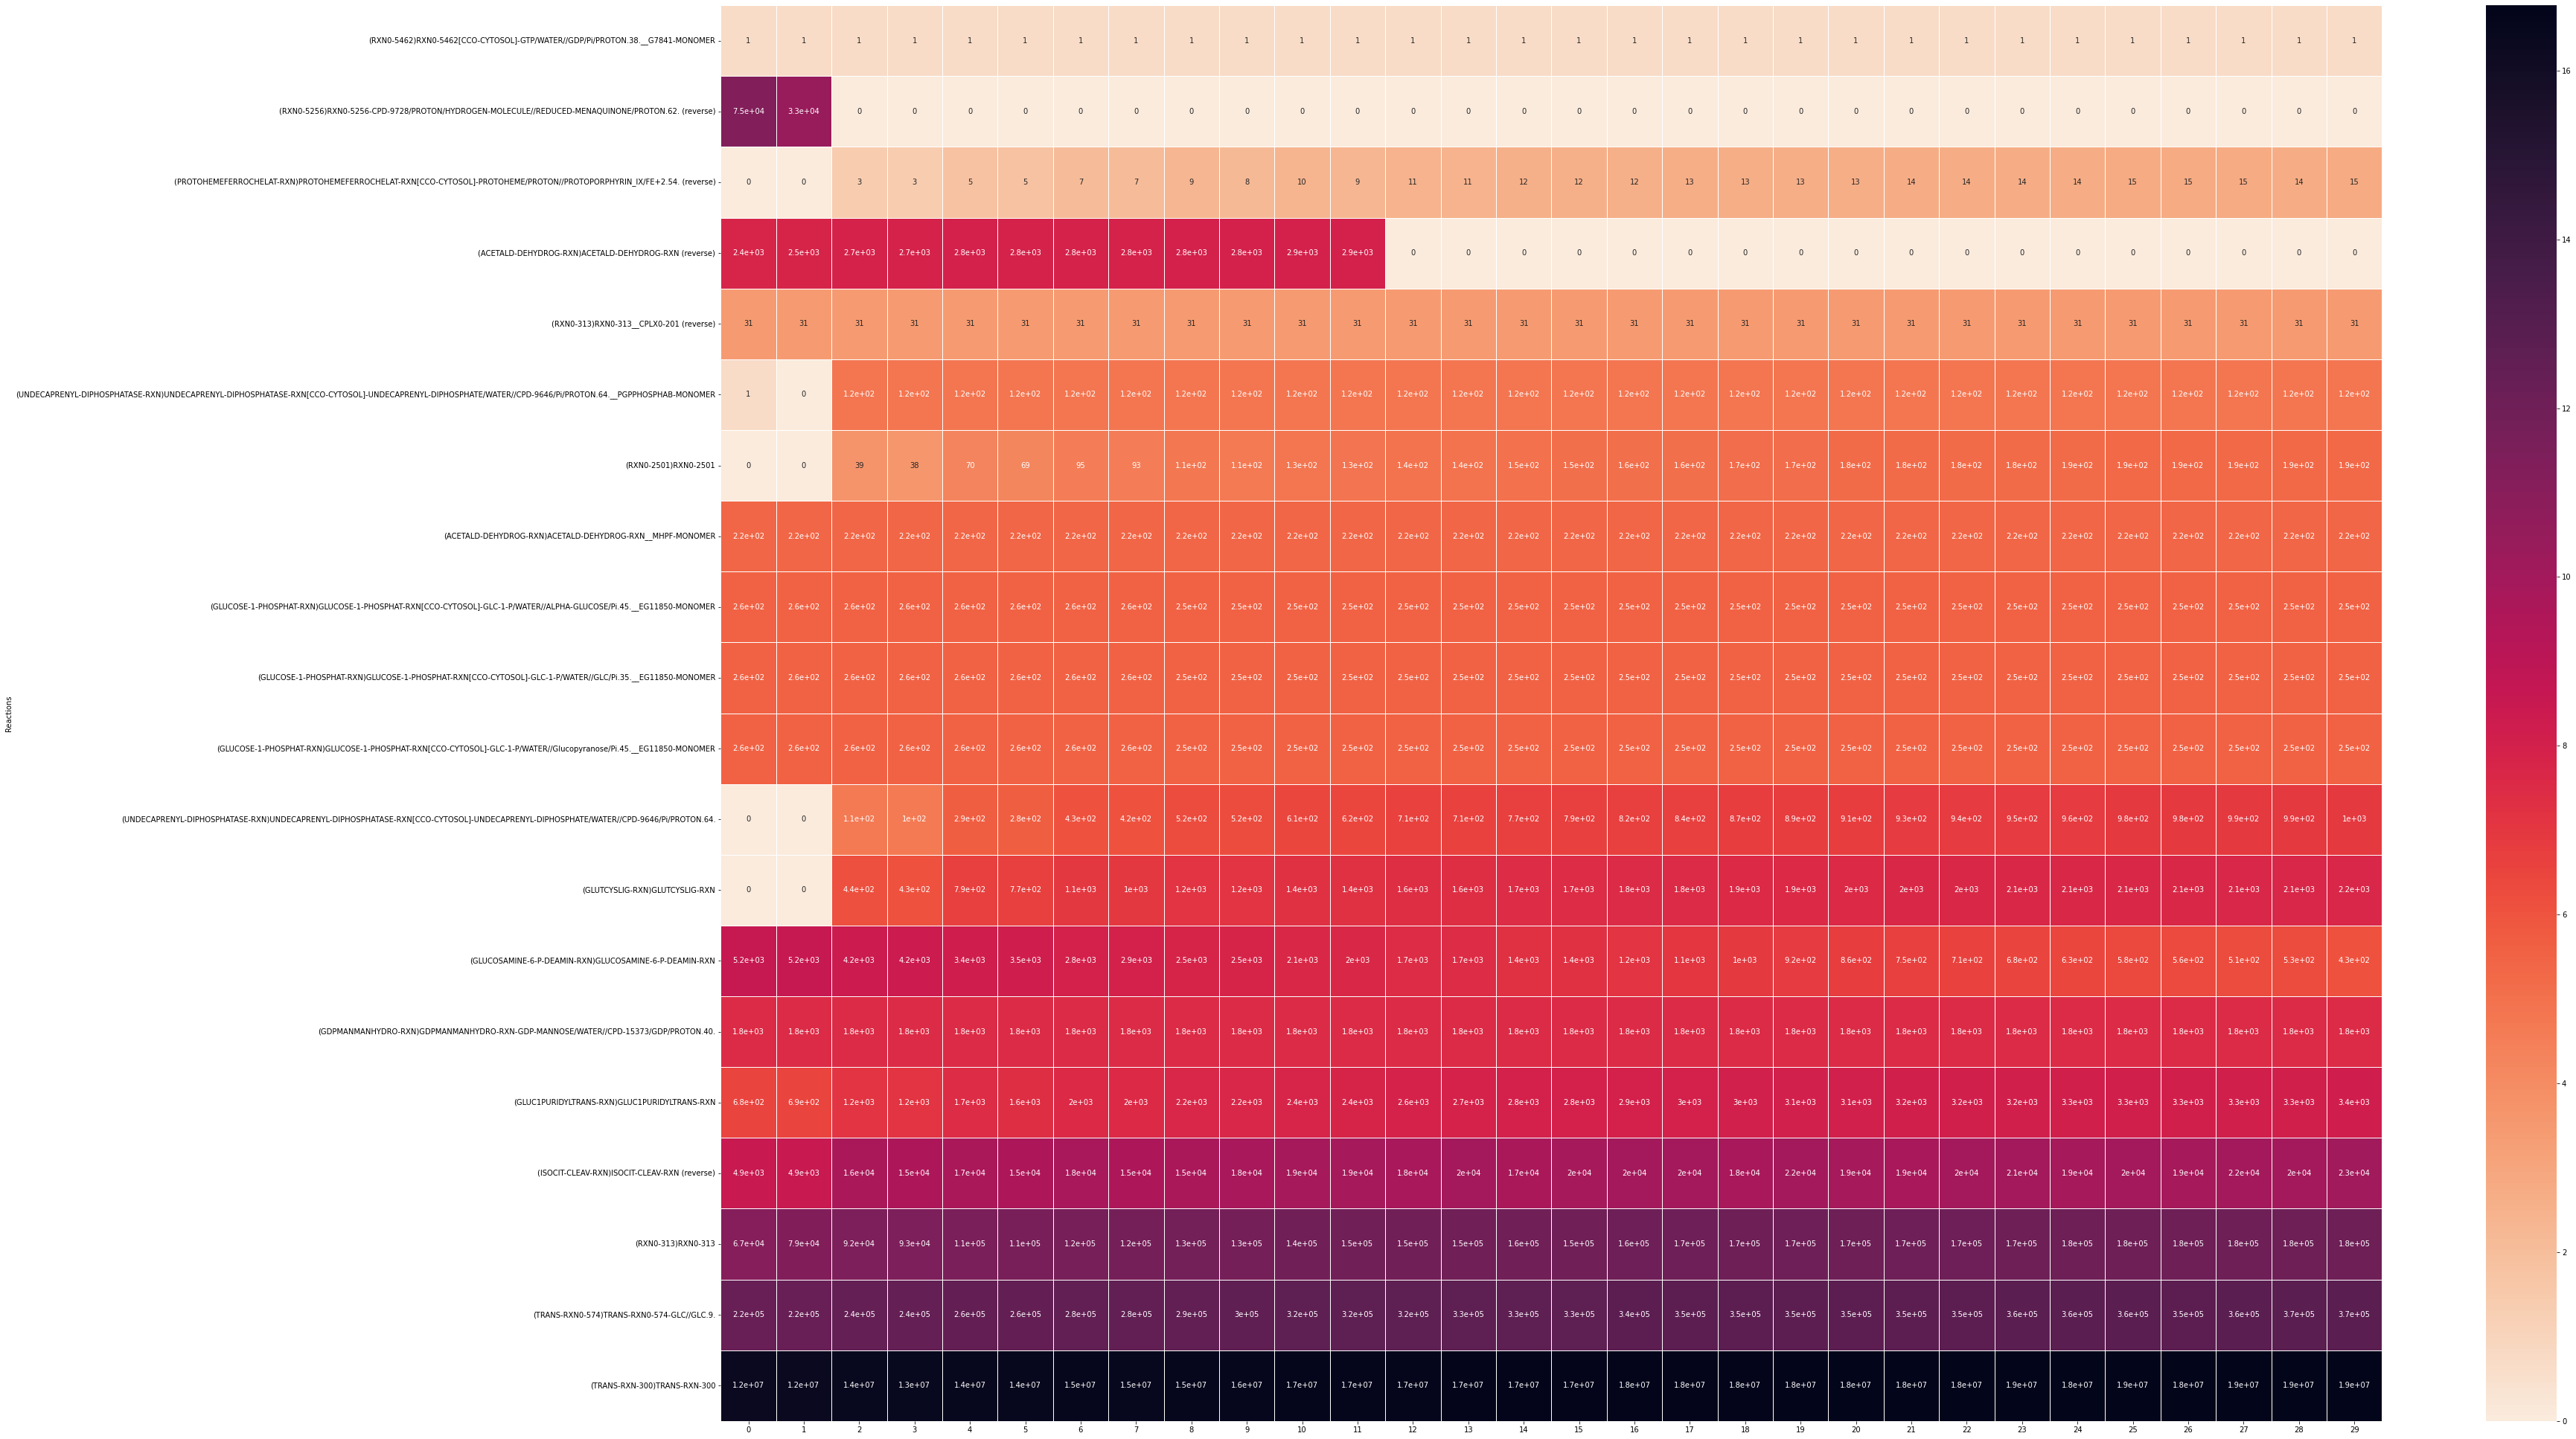

In [10]:
createHeatMapFluxes(foundReactions, 35, True)

### **EcoCyc Comparison: Stoichiometry**

#### *Run following block to validate metabolite compartments*

In [12]:
incorrect = []

for reaction in rxn_metabolites.keys():
    for metabolite in rxn_metabolites[reaction].keys():
        if not (metabolite[len(metabolite) - 1 - 2] == '[' and metabolite[len(metabolite) - 1] == ']'):
            incorrect.append((reaction, metabolite))

print(len(incorrect), "incorrect compartments found.")
enter = input("Press 'Enter' to show metabolite names. Click any other key to contintue")
if enter == "":
    print(incorrect)

142 incorrect compartments found.


Press 'Enter' to show metabolite names. Click any other key to contintue sfd


#### *Run following block to validate complexation/stoichiometry for EcoCyc reactions found in Sim*

**Please run Block A first**

In [ ]:
incorrect = []
ecDict = dict(zip(ecData.reactionID, ecData.stoichiometry))

errors = []

for reaction in foundReactions.keys():
    if "(reverse)" not in reaction:
        x = 0
        origKey = ""
        newKey = ""

        for i in range(len(reaction)):
            if x >= 2:
                newKey = reaction[i:]
                break
            if reaction[i] == '(' or reaction[i] == ')':
                x += 1
            else:
                origKey += reaction[i]

        ec_stoich1 = ecDict[origKey]
        sim_stoich = rxn_metabolites[newKey]
        ec_stoich = ast.literal_eval(ec_stoich1)

        temp = sim_stoich.keys()
        sim_stoich_new = {}

        for metabolite in temp:
            woutComp = metabolite[0:len(metabolite) - 3]
            if woutComp not in sim_stoich_new.keys():
                sim_stoich_new[woutComp] = sim_stoich[metabolite]
            else:
                temp = [sim_stoich_new[woutComp], sim_stoich[metabolite]]
                sim_stoich_new[woutComp] = temp

        for key in sim_stoich_new.keys():
            if key in ec_stoich.keys():
                a = sim_stoich_new[key]
                b = ec_stoich[key]
                if type(a) is list and type(b) is list:
                    a = list(a)
                    b = list(b)
                if not a == b:
                        errors.append(("Discrepency in stoichiometry:", reaction, key, sim_stoich_new[key], ec_stoich[key]))            
            else:
                errors.append(("Metabolite not in EcoCyc Data:", reaction, key))
            
print(len(errors), "discrepencies found: ")
x = input("Click 'Enter' to show errors. Click any other key to continue")
if x == "":
    print(errors)

### **EcoCyc Comparison: Complexes**

In [14]:
ecComplexes = []
ecDict1 = list(ecData["protein_complexes"])

for s in ecDict1:
    s1 = s.replace("[", "")
    s2 = s1.replace("]", "")
    s3 = s2.replace("\'", "")
    sLi = s3.split(", ")
    ecComplexes += sLi

#### *Run following block to identify EcoCyc complexes not in Sim Data complexes*

In [15]:
complexes_edit = []
notPresent1 = []

for complex1 in complexes.keys():
    woutComp = complex1[0:len(complex1) - 3]
    complexes_edit.append(woutComp)
    
for complex2 in ecComplexes:
    if complex2 not in complexes_edit:
        notPresent1.append(complex2)
        
print(len(notPresent1), "complexes not found.")
enter = input("Press 'Enter' to show complex names. Click any other key to contintue")

if enter == "":
    print(notPresent1)
    
for x in notPresent1:
    if x not in ecComplexes:
        print(a)

12 complexes not found.


Press 'Enter' to show complex names. Click any other key to contintue sdf


#### *Run following block to identify EcoCyc complexes with no concentration in Sim Data*

In [16]:
zeroQuantg = []
for key in complexes.keys():
    if notPresent(key, complexes):
        zeroQuantg.append(key)
        
zQuant_edit = []

for complex14 in zeroQuantg:
    woutComp = complex14[0:len(complex14) - 3]
    zQuant_edit.append(woutComp)
    
ecZQuant = []
for comp in ecComplexes:
    if comp in zQuant_edit:
        ecZQuant.append(comp)
        
print(len(ecZQuant), "complexes found.")
enter = input("Press 'Enter' to show complex names. Click any other key to contintue")

if enter == "":
    print(ecZQuant)

19 complexes found.


Press 'Enter' to show complex names. Click any other key to contintue sdf


#### *Run following block to visualize EcoCyc complexes with concentration in Sim Data*

**Run all blocks in this section before this one**

In [ ]:
neccComp = []

for x in ecComplexes:
    if not (x in notPresent1 or x in ecZQuant):
        neccComp.append(x)

complexes_edit_dict = {}
for complex5 in complexes.keys():
    woutComp = complex5[0:len(complex5) - 3]
    complexes_edit_dict[woutComp] = complexes[complex5]

temp = {}

for comp in neccComp:
    temp[comp] = complexes_edit_dict[comp]
        
createHeatMapComplexes(temp, 200, False)